In [1]:
%reset -f
from pythonrc import *

In [2]:

time_step = 0.01


# tunnel.extra_attributes['rate_limit'] = 0.1
# voithschneider_port.extra_attributes['rate_limit'] = 0.1
# voithschneider_starboard.extra_attributes['rate_limit'] = 0.1

del voithschneider_port.extra_attributes['reference_angle']
del voithschneider_starboard.extra_attributes['reference_angle']


actuators = [tunnel, voithschneider_port, voithschneider_starboard]
for a in actuators:
    a.extra_attributes['rate_limit'] = 0.1

force_torque_components = [
    skadipy.allocator.ForceTorqueComponent.X,
    skadipy.allocator.ForceTorqueComponent.Y,
    skadipy.allocator.ForceTorqueComponent.N,
]

allocators = []
gamma = [0.1,0.1, 0.1]
mu    = [0.1,0.1, 0.1]
rho   = [0.1,1.0, 10.0]
lambda_p = [0.9,0.9, 0.9]


for g,m,r,l in zip(gamma, mu, rho, lambda_p):

    allocators.append(skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth(
        actuators=actuators, force_torque_components=force_torque_components, control_barrier_function=skadipy.safety.ControlBarrierFunctionType.ABSOLUTE,
        gamma=g, mu=m, rho=r, time_step=time_step, lambda_=l
    ))



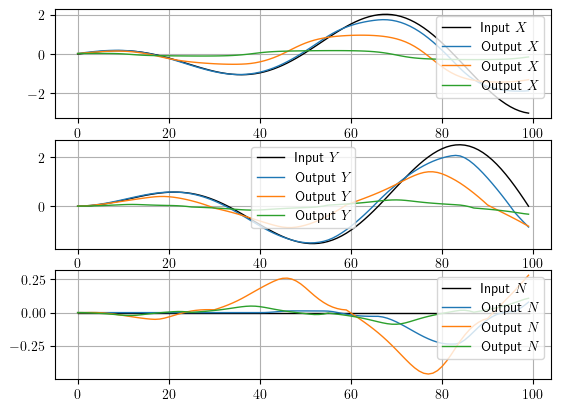

In [3]:
data = generate_spiral_dataset(
    num_points=100,
    num_turns=1.5,
    k=3
)

tau_cmd = np.concatenate(
    (data, np.zeros((np.shape(data)[0], 4))),
    axis=1
)

d_tau_cmd = np.gradient(tau_cmd, axis=0) / time_step

xi_hist, theta_hist, tau_hist = run_tests(tau_cmd=tau_cmd, d_tau_cmd=d_tau_cmd, allocators=allocators)
plot_histories(tau_cmd=tau_cmd, tau_alloc=tau_hist)

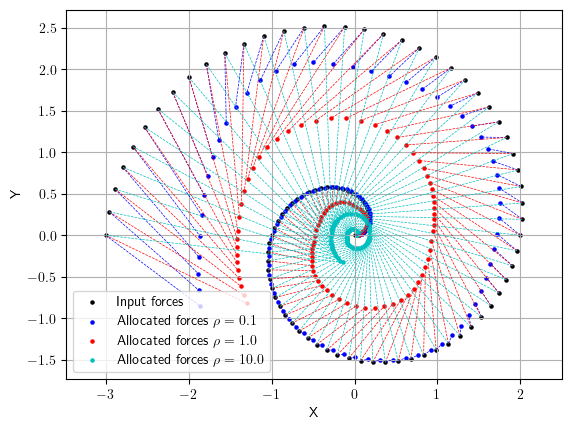

In [4]:

plt.scatter(data[:, 0], data[:, 1], s=5, label="Input forces", color='black')

colors = ['b','r','c']
for _, F,color, r in zip(allocators, tau_hist, colors, rho):
    plt.scatter(F[:, 0], F[:, 1], s=5, label=rf"Allocated forces $\rho={r}$", color=color)
    for i in range(len(data)):
        plt.plot([data[i, 0], F[i, 0]], [data[i, 1], F[i, 1]], "--", color=color, lw=0.5)

plt.grid(True)
plt.axis('equal')
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

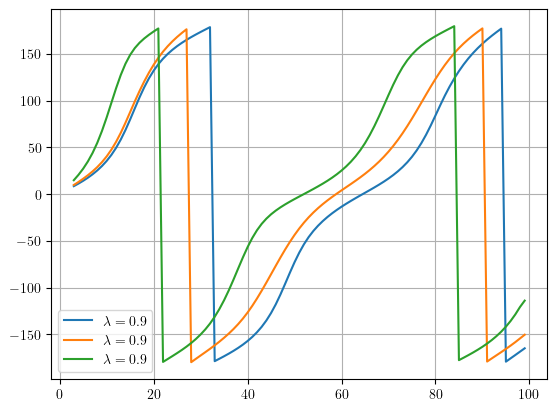

In [5]:
angles = []
for xi in xi_hist:
    a = np.empty((len(xi), 2))
    for i, u in enumerate(xi):
        a2 = np.arctan2(u[2], u[1])
        a3 = np.arctan2(u[4], u[3])
        a[i] = np.array([a3])
    angles.append(a)

for _, angle in enumerate(angles):
    angle[0:3,0] = None

plt.clf()
for _, angle in enumerate(angles):
    plt.plot(np.degrees(angle[:,0]))


l = []
for i in lambda_p:
    l.append(f"$\lambda = {i}$")

plt.legend(l)
plt.grid(True)

In [6]:
# save_mat(
#     filename="data/14.mat",
#     inputs=tau,
#     xi=xi_all,
#     thetas=theta_all,
#     outputs=allocated,
#     rho=rho,
#     gamma=gamma,
#     mu=mu,
#     lambda_p=lambda_p,
#     thruster=voithschneider_port
# )